In [1]:
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

from torchvision import transforms

from torch import nn, optim

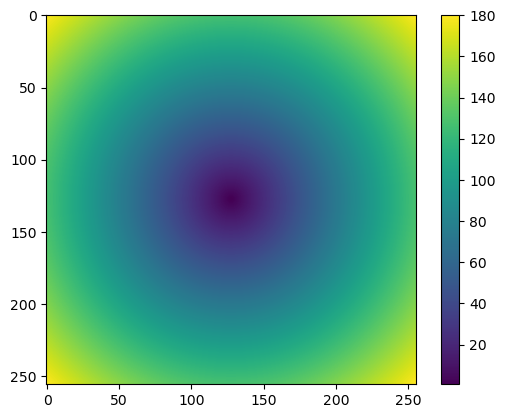

In [2]:
# Demo the distance matrix
## Add distance
dist = torch.zeros(256, 256)

for i in range(256):
    for j in range(256):
        dist[i, j] = np.sqrt((i - 127.5)**2 + (j-127.5)**2)
        
plt.imshow(dist)
plt.colorbar()
plt.show()

In [154]:
dist.min()

tensor(0.7071)

In [3]:
t_trans = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

class OneHotImages(Dataset):
    def __init__(self, file_path, transforms=None):
        self.file_path = file_path

        # Images
        self.files = os.listdir(os.path.join(file_path, "img"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = torch.load(os.path.join(self.file_path, "img", self.files[idx]))

        with open(
            os.path.join(self.file_path, "labels", self.files[idx][:-3] + ".txt")
        ) as fp:
            label = float(fp.read())
        # Omit the tree class
        return img[:, :, [0,1,3]], torch.tensor(label, dtype=torch.float)

In [4]:
train = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/train", transforms = t_trans)
test = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/test")

In [281]:
class ExpModel(nn.Module):
    def __init__(self):
        super(ExpModel, self).__init__()
        self.intercept = 74 # nn.Parameter(torch.tensor(75.))
        
        self.magnitude = nn.Parameter(torch.rand(3))
        self.variance = nn.Parameter(torch.rand(3))
        
        # Initialize values to be in a reasonable range
        torch.nn.init.uniform_(self.magnitude, a = 0, b = 1)
        torch.nn.init.uniform_(self.variance, a = 5, b = 6)
        
        ## Add distance
        self.dist = torch.zeros(256, 256, device='cuda')
        
        for i in range(256):
            for j in range(256):
                self.dist[i, j] = np.sqrt((i - 127.5)**2 + (j-127.5)**2)**2
                
        self.dist = torch.repeat_interleave(self.dist.unsqueeze(-1), 3, 2)
        
        self.to('cuda')
                
    def forward(self, X):
        res = (X * self.magnitude * torch.exp(-self.dist / self.variance)).sum(dim=(1,2,3))
#         res = torch.sum(res * torch.exp(self.magnitude), dim = 1)
        return self.intercept + res


In [270]:
X.sum(dim=(1,2,3))

tensor([42768, 37711, 32580, 32943, 43354, 55043, 46298, 46886, 55694, 48215,
        24884, 62235, 40153, 16207, 44934, 31532, 33913, 39488, 21228, 32542,
        36227, 38992, 46582, 21693, 27825, 24336, 52221, 26005, 56443, 30327,
        26920, 24264, 40007, 52019, 38273, 43313, 52781, 35882, 46875, 29630,
        33493, 35569, 29177, 41940, 33096, 38454, 45254, 35656, 24879, 54500,
        14131, 34560, 46754, 22424, 28822, 48727, 18095, 36114, 55020, 44162,
        24230, 32455, 23054, 25889], device='cuda:0')

In [282]:
model = ExpModel()

In [283]:
train_loader = DataLoader(train, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

In [284]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [285]:
for epoch in range(10):
    print(f"Epoch {epoch}")
    train_loss = 0
    count = 0
    model.train()
    for X, y in train_loader:
        X = X.to('cuda')
        y = y.to('cuda')

        optimizer.zero_grad()
        y_hat = model(X)
        loss = F.mse_loss(y_hat, y)

        loss.backward()

        optimizer.step()
        
        train_loss += loss.item() * X.size(0)
        count += X.size(0)
        
    print(f"Train loss: {train_loss / count}")
    model.eval()
    test_loss = 0
    count = 0
    for X, y in test_loader:
        X = X.to('cuda')
        y = y.to('cuda')

        y_hat = model(X)
        loss = F.mse_loss(y_hat, y)
        
        test_loss += loss.item() * X.size(0)
        count += X.size(0)
        
    print(f"Test loss: {test_loss / count}")

Epoch 0
Train loss: 11.839711951398698
Test loss: 11.638276319326081
Epoch 1
Train loss: 9.875592152699907
Test loss: 8.274452422716603
Epoch 2
Train loss: 9.300816354538759
Test loss: 8.036419874392681
Epoch 3
Train loss: 9.178393917306703
Test loss: 8.180397708963904
Epoch 4
Train loss: 9.154763237956226
Test loss: 8.365364447883938
Epoch 5
Train loss: 9.146837291251334
Test loss: 8.439586497241665
Epoch 6
Train loss: 9.130339743100368
Test loss: 8.334681001509198
Epoch 7
Train loss: 9.097386090585706
Test loss: 8.150451867476754
Epoch 8
Train loss: 9.055719914775853
Test loss: 8.057375759811876
Epoch 9
Train loss: 9.017967036629331
Test loss: 8.089669180212553


In [275]:
loss

tensor(6.6740, device='cuda:0', grad_fn=<MseLossBackward0>)

In [276]:
model.intercept

75

In [277]:
print(model.magnitude)

Parameter containing:
tensor([0.4178, 0.3758, 0.4965], device='cuda:0', requires_grad=True)


In [278]:
model.variance

Parameter containing:
tensor([5.8836, 5.8735, 5.0993], device='cuda:0', requires_grad=True)

-2.0922215745467745
6.6677995


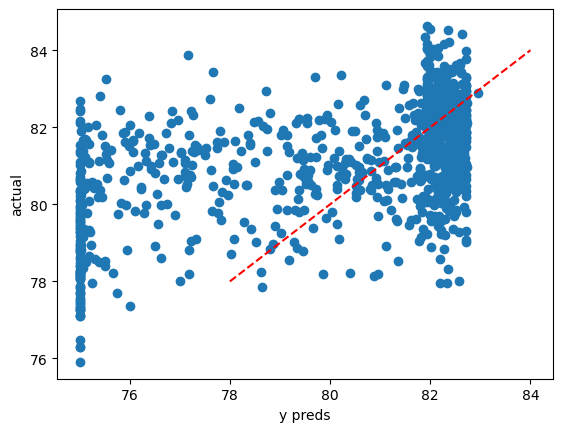

In [279]:
y_preds = []
y_actual = []
with torch.no_grad():
    for X, y in train_loader:
        X = X.to('cuda')
        y_actual.extend(y.numpy())

        y_hat = model(X)
        y_preds.extend(y_hat.cpu().numpy())
        
print(r2_score(y_actual, y_preds))
print(np.mean((np.array(y_actual) - np.array(y_preds))**2))
plt.scatter(y_preds, y_actual)
plt.plot(np.linspace(78, 84, 2), np.linspace(78, 84, 2), 'r--')
plt.xlabel("y preds")
plt.ylabel("actual")
plt.show()

-0.8638361626055704


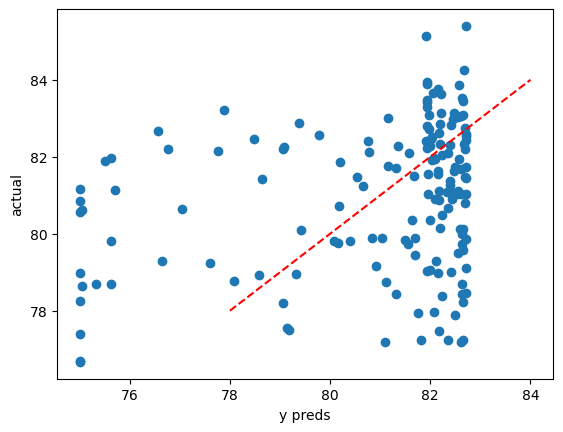

In [280]:
# Look at test results
y_preds = []
y_actual = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to('cuda')
        y_actual.extend(y.numpy())

        y_hat = model(X)
        y_preds.extend(y_hat.cpu().numpy())
    
print(r2_score(y_actual, y_preds))
plt.scatter(y_preds, y_actual)
plt.plot(np.linspace(78, 84, 2), np.linspace(78, 84, 2), 'r--')
plt.xlabel("y preds")
plt.ylabel("actual")
plt.show()

In [303]:
X_train_s = []
y_train_s = []
for X, y in train_loader:
    X_train_s.append(X[0].numpy().mean(axis=(0,1)))
    y_train_s.append(y[0].item())
    
    
X_test_s = []
y_test_s = []
for X, y in test_loader:
    X_test_s.append(X[0].numpy().mean(axis=(0,1)))
    y_test_s.append(y[0].item())
    

In [304]:
X_train_s = np.array(X_train_s)
X_test_s = np.array(X_test_s)

In [305]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train_s, y_train_s)

LinearRegression()

In [306]:
preds = lm.predict(X_test_s)

In [307]:
r2_score(y_test_s, preds)

0.25651230021743976

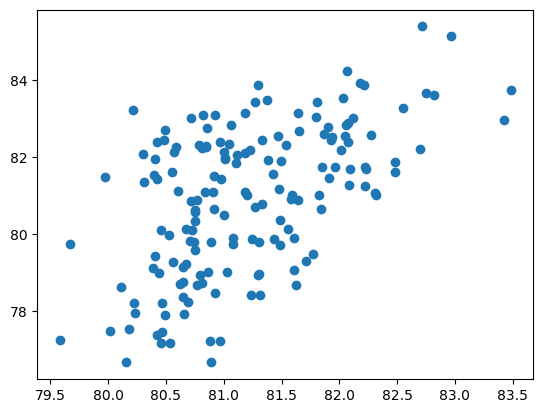

In [309]:
plt.scatter(preds, y_test_s)

In [310]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(X_train_s, y_train_s)

preds = dt.predict(X_test_s)

r2_score(y_test_s, preds)

-0.3615071020071128

In [313]:
lm.coef_

array([-0.20859339, -3.0248333 , -4.3525533 ,  7.58597999])

In [315]:
lm.intercept_

83.54279165744097

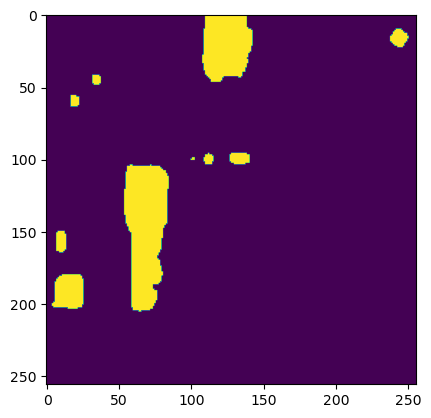

In [185]:
plt.imshow(X[0,:, :, 3].cpu().numpy())

In [176]:
len(y_actual)

941

In [177]:
model.intercept

Parameter containing:
tensor(78.9949, device='cuda:0', requires_grad=True)